In [1]:
import pandas as pd
import numpy as np
import io
import requests
import datetime
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

# Loading in your data set

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fe33ee320>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fe12e54a8>]], dtype=object)

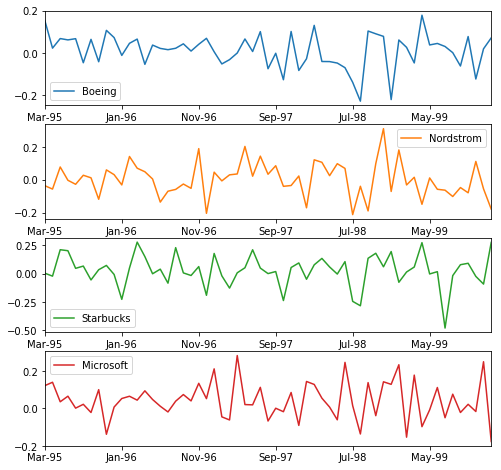

In [2]:
url="https://raw.githubusercontent.com/ymlai87416/PythonPlayground/master/Python%20notebook/lab9.csv"
s=requests.get(url).content
returns_df=pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0, infer_datetime_format=True)

%matplotlib inline
returns_df.plot(subplots=True, layout=(4, 1), figsize=(8,8), sharex=False)

# The CER model

mu_hat_month
Boeing       0.011300
Nordstrom    0.001545
Starbucks    0.028461
Microsoft    0.042712
dtype: float64
sigma2_month
Boeing       0.006476
Nordstrom    0.011121
Starbucks    0.020212
Microsoft    0.010122
dtype: float64
sigma_month
Boeing       0.080473
Nordstrom    0.105456
Starbucks    0.142170
Microsoft    0.100609
dtype: float64
cov_mat_month
             Boeing  Nordstrom  Starbucks  Microsoft
Boeing     0.006476   0.000870   0.003473   0.000693
Nordstrom  0.000870   0.011121   0.002636   0.001850
Starbucks  0.003473   0.002636   0.020212   0.001131
Microsoft  0.000693   0.001850   0.001131   0.010122
cor_mat_month
             Boeing  Nordstrom  Starbucks  Microsoft
Boeing     1.000000   0.102516   0.303605   0.085541
Nordstrom  0.102516   1.000000   0.175829   0.174393
Starbucks  0.303605   0.175829   1.000000   0.079037
Microsoft  0.085541   0.174393   0.079037   1.000000


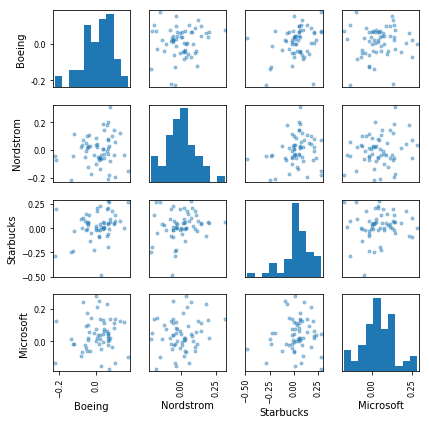

In [3]:
# Parameters CER model
mu_hat_month = returns_df.mean()
print('mu_hat_month')
print(mu_hat_month)

sigma2_month = returns_df.var()
print('sigma2_month')
print(sigma2_month)

sigma_month = returns_df.std()
print('sigma_month')
print(sigma_month)

cov_mat_month = returns_df.cov()
print('cov_mat_month')
print(cov_mat_month)

cor_mat_month = returns_df.corr()
print('cor_mat_month')
print(cor_mat_month)

# Pairwise scatterplots
#pairs(coredata(returns_df), col="blue", pch=16

%matplotlib inline
axes = pd.tools.plotting.scatter_matrix(returns_df, alpha=0.4, figsize=(6,6))
plt.tight_layout()
plt.show()

# The global minimum variance portfolio - Part One

In [5]:
#source from https://blog.quantopian.com/markowitz-portfolio-optimization-2/

#parameters:
#      expectedReturn as a vector with dimension n X 1
#      covarianceMatrix as a matrix with dimension n X n

def optimal_portfolio(expectReturn, covarianceMatrix, short=False):
    # Convert to cvxopt matrices
    n = len(expectReturn)

    pbar = opt.matrix(np.asmatrix(expectReturn))
    S = opt.matrix(np.asmatrix(covarianceMatrix))

    # Create constraint matrices
    P = S
    q = opt.matrix(0.0, (n, 1))
    if short:
        G = -opt.matrix(0.0, (n ,n))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n ,1))
    else:
        G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n ,1))
        
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    wt = solvers.qp(P, q, G, h, A, b)['x']
    
    wt = np.asarray(wt)
    returns = np.matmul(wt.transpose(), expectReturn)
    risks = np.sqrt(wt.transpose() * np.asmatrix(covarianceMatrix) * wt)

    return {'weight': wt, 'er': np.asscalar(returns), 'sd':np.asscalar(risks) }

     pcost       dcost       gap    pres   dres
 0:  1.7565e-03  1.7565e-03  4e+00  2e+00  1e-18
 1:  1.7565e-03  1.7565e-03  4e-02  2e-02  8e-19
 2:  1.7565e-03  1.7565e-03  4e-04  2e-04  0e+00
 3:  1.7565e-03  1.7565e-03  4e-06  2e-06  0e+00
 4:  1.7565e-03  1.7565e-03  4e-08  2e-08  0e+00
Optimal solution found.

global_min_var_portfolio
{'er': 0.01846120419062357, 'sd': 0.05927077012967872, 'weight': array([[ 0.45620423],
       [ 0.22325179],
       [ 0.05122716],
       [ 0.26931682]])}


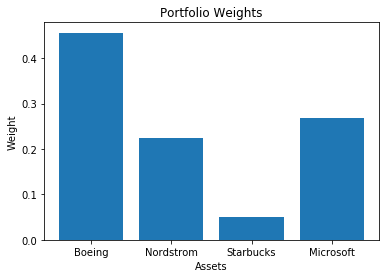

In [6]:
# Calculate the global minimum variance portfolio
global_min_var_portfolio = optimal_portfolio(mu_hat_month, cov_mat_month, short=True)

print('\nglobal_min_var_portfolio')
print(global_min_var_portfolio)

n = returns_df.columns.size

# Plot the portfolio weights of our four stocks
#Plot the optimial weight
plt.figure();
plt.bar(range(n), global_min_var_portfolio['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# The global minimum variance portfolio - Part Two

The Markowitz portfolio optimization problem for the minimum variance portfolio with no short sales restrictions can be described as follows:

$$\min\limits_{x} \sigma^2_{p,x}=x'\sum x, \ subject \ to$$

$$x'1=1$$

$$x_i \geq 0,$$


Using CVXOPT, Quadratic programming problems are of the form:

$$\min\limits_{x} \frac{1}{2}x'Px + q'x, \ subject \  to$$

$$Gx \preceq h $$

$$Ax = b $$


In [8]:
# set restriction matrices
n = returns_df.columns.size

P = 2* opt.matrix(np.asmatrix(cov_mat_month))
q = opt.matrix(0.0, (n, 1))
G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# use solve.QP to minimize portfolio variance
quad_prog = solvers.qp(P, q, G, h, A, b)

print('solution')
print(quad_prog['x'])
print('objective value at solution')
print(quad_prog['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  4.2914e-03 -9.9853e-01  1e+00  2e-16  3e+00
 1:  4.2744e-03 -8.5096e-03  1e-02  2e-16  3e-02
 2:  3.7937e-03  2.2737e-03  2e-03  1e-16  3e-03
 3:  3.5336e-03  3.3867e-03  1e-04  6e-17  3e-18
 4:  3.5135e-03  3.5027e-03  1e-05  1e-16  2e-18
 5:  3.5130e-03  3.5129e-03  2e-07  1e-16  2e-18
 6:  3.5130e-03  3.5130e-03  2e-09  8e-17  1e-18
Optimal solution found.
solution
[ 4.56e-01]
[ 2.23e-01]
[ 5.12e-02]
[ 2.69e-01]

objective value at solution
0.0035130241917785384


# The global minimum variance portfolio - End game

     pcost       dcost       gap    pres   dres
 0:  2.1545e-03 -9.9928e-01  1e+00  6e-17  3e+00
 1:  2.1501e-03 -9.2700e-03  1e-02  8e-17  3e-02
 2:  1.9571e-03  9.2947e-04  1e-03  7e-17  2e-03
 3:  1.7727e-03  1.6554e-03  1e-04  2e-16  1e-18
 4:  1.7570e-03  1.7482e-03  9e-06  6e-17  7e-19
 5:  1.7565e-03  1.7563e-03  2e-07  2e-16  5e-19
 6:  1.7565e-03  1.7565e-03  2e-09  1e-16  5e-19
Optimal solution found.

global_min_var_portfolio
{'er': 0.018461235634820394, 'sd': 0.05927077013026689, 'weight': array([[ 0.45620298],
       [ 0.2232513 ],
       [ 0.05122912],
       [ 0.2693166 ]])}


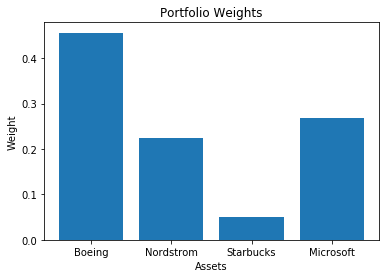

In [10]:
# Calculate the global minimum variance portfolio
global_min_var_portfolio = optimal_portfolio(mu_hat_month, cov_mat_month, short=False)

print('\nglobal_min_var_portfolio')
print(global_min_var_portfolio)

n = returns_df.columns.size

# Plot the portfolio weights of our four stocks
#Plot the optimial weight
plt.figure();
plt.bar(range(n), global_min_var_portfolio['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# An efficient portfolio

The minimization problem if short selling is allowed is:

$$\min\limits_{x} \sigma^2_p=x'\sum x, \ subject\ to$$

$$x'\mu=\mu_0,$$

$$x'1=1,$$

with $\mu_0$ the target return and other symbols as defined before.

If you do not allow for short sales, the following constraint is added:

$$x_i \geq 0\ for\ all\ i.$$

In [12]:
#source from https://blog.quantopian.com/markowitz-portfolio-optimization-2/

#parameters:
#      expectedReturn as a vector with dimension n X 1
#      covarianceMatrix as a matrix with dimension n X n
#      targetReturn as the target return, should be the maximum of expectReturn in normal case.
#      short to indicate if short selling is allowed.

def efficient_portfolio(expectReturn, covarianceMatrix, targetReturn, short=False):
    # Convert to cvxopt matrices
    n = len(expectReturn)

    pbar = opt.matrix(np.asmatrix(expectReturn))
    S = opt.matrix(np.asmatrix(covarianceMatrix))

    # Create constraint matrices
    P = S
    q = opt.matrix(0.0, (n, 1))
    if short:
        G = -opt.matrix(0.0, (n ,n))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n ,1))
    else:
        G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n ,1))

    A = opt.matrix([pbar, opt.matrix(1.0, (1, n))])
    b = opt.matrix([opt.matrix(targetReturn), opt.matrix(1.0)])
    
    wt = solvers.qp(P, q, G, h, A, b)['x']
    
    wt = np.asarray(wt)
    returns = np.matmul(wt.transpose(), expectReturn)
    risks = np.sqrt(wt.transpose() * np.asmatrix(covarianceMatrix) * wt)

    return {'weight': wt, 'er': np.asscalar(returns), 'sd':np.asscalar(risks) }

     pcost       dcost       gap    pres   dres
 0:  4.1507e-03  4.1507e-03  4e+00  2e+00  3e-18
 1:  4.1507e-03  4.1507e-03  4e-02  2e-02  4e-18
 2:  4.1507e-03  4.1507e-03  4e-04  2e-04  2e-19
 3:  4.1507e-03  4.1507e-03  4e-06  2e-06  2e-18
 4:  4.1507e-03  4.1507e-03  4e-08  2e-08  2e-18
Optimal solution found.
{'er': 0.042711837288135594, 'sd': 0.09111197479523411, 'weight': array([[ 0.14034934],
       [-0.18522823],
       [ 0.2257157 ],
       [ 0.81916318]])}


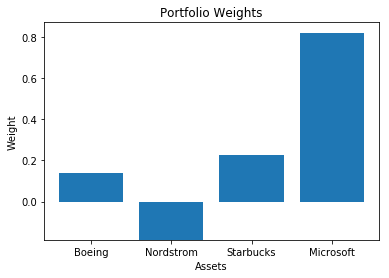

     pcost       dcost       gap    pres   dres
 0:  4.4974e-03 -9.9701e-01  8e+00  2e+00  3e+00
 1:  4.3076e-03 -3.3992e-01  7e-01  1e-01  2e-01
 2:  5.0507e-03  1.6169e-03  1e-02  3e-03  5e-03
 3:  5.0610e-03  5.0267e-03  1e-04  3e-05  5e-05
 4:  5.0611e-03  5.0608e-03  1e-06  3e-07  5e-07
 5:  5.0611e-03  5.0611e-03  1e-08  3e-09  5e-09
Optimal solution found.
{'er': 0.04271183728813559, 'sd': 0.10060919592567705, 'weight': array([[  3.88080593e-10],
       [ -8.16971106e-10],
       [  1.50459207e-09],
       [  9.99999999e-01]])}


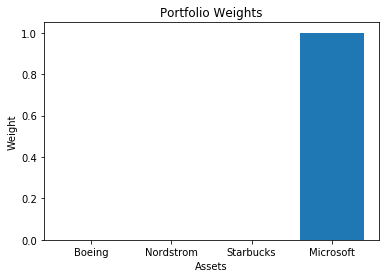

In [13]:
# highest average return
mu_target = np.max(mu_hat_month)

# short sales allowed
efficient_porfolio_short = efficient_portfolio(mu_hat_month, cov_mat_month, mu_target, short=True)

print(efficient_porfolio_short)

# Plot the portfolio weights of our four stocks
#Plot the optimial weight
plt.figure();
plt.bar(range(n), efficient_porfolio_short['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# no short sales allowed
efficient_porfolio_no_short = efficient_portfolio(mu_hat_month, cov_mat_month, mu_target, short=False)

print(efficient_porfolio_no_short)

plt.figure();
plt.bar(range(n), efficient_porfolio_no_short['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# The efficient frontier
$$z=\alpha∗m+(1−\alpha)∗x$$

for values of $\alpha$ being between −1 and 1, with $m$ the vector of portfolio weights of the global minimum variance portfolio and with $x$ the vector of portfolio weights of the efficient portfolio that was calculated in the previous exercise.

In [15]:
def efficient_frontier(expectedReturn, covarianceMatrix, nport=20, alphaMin=0.5, alphaMax=0.5, short=False):
    opt_portfolio = optimal_portfolio(expectedReturn, covarianceMatrix, short)
    mu_target = np.max(expectedReturn)
    eff_portfolio = efficient_portfolio(expectedReturn, covarianceMatrix, mu_target, short)
    
    a = np.linspace(start=alphaMin, stop=alphaMax, num=nport)
    weights = np.outer(a, opt_portfolio['weight']) + np.outer((1-a), eff_portfolio['weight'])
    
    returns = np.matmul(weights, expectedReturn)
    returns = np.asarray(returns)
    
    cov = np.matmul(np.matmul(weights, covarianceMatrix), weights.transpose())
    sd = np.sqrt(np.diag(cov))
    sd = np.asarray(sd)
    
    return {'er': returns, 'sd':sd, 'weight': weights}

     pcost       dcost       gap    pres   dres
 0:  2.1545e-03 -9.9928e-01  1e+00  6e-17  3e+00
 1:  2.1501e-03 -9.2700e-03  1e-02  8e-17  3e-02
 2:  1.9571e-03  9.2947e-04  1e-03  7e-17  2e-03
 3:  1.7727e-03  1.6554e-03  1e-04  2e-16  1e-18
 4:  1.7570e-03  1.7482e-03  9e-06  6e-17  7e-19
 5:  1.7565e-03  1.7563e-03  2e-07  2e-16  5e-19
 6:  1.7565e-03  1.7565e-03  2e-09  1e-16  5e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.4974e-03 -9.9701e-01  8e+00  2e+00  3e+00
 1:  4.3076e-03 -3.3992e-01  7e-01  1e-01  2e-01
 2:  5.0507e-03  1.6169e-03  1e-02  3e-03  5e-03
 3:  5.0610e-03  5.0267e-03  1e-04  3e-05  5e-05
 4:  5.0611e-03  5.0608e-03  1e-06  3e-07  5e-07
 5:  5.0611e-03  5.0611e-03  1e-08  3e-09  5e-09
Optimal solution found.


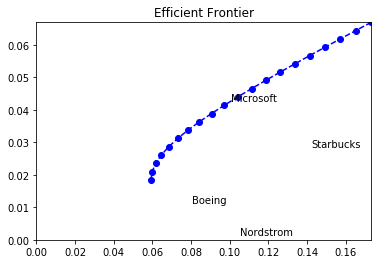

In [16]:
eff_frontier = efficient_frontier(mu_hat_month, cov_mat_month, 20, -1, 1)

plt.plot(eff_frontier['sd'], eff_frontier['er'], 'r--', c='b', marker='o')
#for x, y, in zip(eff_frontier['sd'], eff_frontier['er']):
#    plt.scatter(x, y, c='b')

plt.text(y=mu_hat_month['Boeing'], x=sigma_month['Boeing'], s="Boeing")
plt.text(y=mu_hat_month['Microsoft'], x=sigma_month['Microsoft'], s="Microsoft")
plt.text(y=mu_hat_month['Nordstrom'], x=sigma_month['Nordstrom'], s="Nordstrom")
plt.text(y=mu_hat_month['Starbucks'], x=sigma_month['Starbucks'], s="Starbucks")
plt.xlim(0, np.max(eff_frontier['sd']))
plt.ylim(0, np.max(eff_frontier['er']))
plt.title("Efficient Frontier")

plt.show()

# The tangency portfolio

Assume the risk-free rate is 0.005 ($r_f = 0.5%$) per month. The tangency portfolio can be found via:

$$\max\limits_{t}\ slope=\frac{\mu_p \text{-} r_f}{σp},\ subject\ to$$

$$\mu_p=t'\mu$$

$$\mu_p=(t'\sum t)^{\frac{1}{2}}$$

$$t'1=1,$$

with $\mu_p$ and $\sigma_p$ the portfolio return and standard deviation respectively, $t$ the vector of portfolio weights, $\mu$ the vector of expected returns and $\sum$ the covariance matrix of the returns.

If you add the condition that no short positions are allowed, the additional constraint that is to be added is $x_i \geq 0$ for $i=1,…,4.$

In [18]:
#tranlsation of tangency.portfolio in https://github.com/algoquant/scripts/blob/master/Zivot%20portfolio.R

#parameters:
#      expectedReturn as a vector with dimension n X 1
#      covarianceMatrix as a matrix with dimension n X n

def tangency_portfolio(expectReturn, covarianceMatrix, riskFreeRate, short=False):

    er = opt.matrix(np.asmatrix(expectReturn))
    covMatrix = opt.matrix(np.asmatrix(covarianceMatrix))
    
    if(riskFreeRate < 0):
        raise TypeError("Risk-free rate must be positive")
    
    if(len(er) != covMatrix.size[0]):
        raise TypeError("invalid inputs")
    
    opt_portfolio = optimal_portfolio(expectReturn, covarianceMatrix, short)
    
    if opt_portfolio['er'] < riskFreeRate:
        raise TypeError("Risk-free rate must be positive")
        
    inv = np.linalg.inv(covMatrix)
    
    if short:
        weights = np.matmul(inv, (er - riskFreeRate))
        weights = weights / np.sum(weights)
    else:
        P = 2 * covMatrix
        q = opt.matrix(0.0, (n ,1))
        excess_er = expectReturn - riskFreeRate
        G = -opt.matrix(np.eye(n))
        h = opt.matrix(0.0, (n ,1))
        A = opt.matrix(excess_er, (1, 4))
        b = opt.matrix(1.0, (1, 1))
        result = solvers.qp(P, q, G, h, A, b)['x']
        weights = np.round(result/np.sum(result), 6)
    
    returns = np.matmul(weights.transpose(), expectReturn)
    risks = np.sqrt(np.matmul(np.matmul(weights.transpose(), np.asmatrix(covarianceMatrix)), weights))
    
    return {'weight': weights, 'er':np.asscalar(returns), 'sd':np.asscalar(risks) }

     pcost       dcost       gap    pres   dres
 0:  1.7565e-03  1.7565e-03  4e+00  2e+00  1e-18
 1:  1.7565e-03  1.7565e-03  4e-02  2e-02  8e-19
 2:  1.7565e-03  1.7565e-03  4e-04  2e-04  0e+00
 3:  1.7565e-03  1.7565e-03  4e-06  2e-06  0e+00
 4:  1.7565e-03  1.7565e-03  4e-08  2e-08  0e+00
Optimal solution found.
{'er': 0.05051326015729413, 'sd': 0.10898521542887256, 'weight': array([[ 0.0387389 ],
       [-0.31663615],
       [ 0.28184862],
       [ 0.99604863]])}


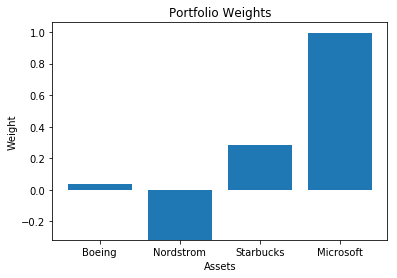

     pcost       dcost       gap    pres   dres
 0:  2.1545e-03 -9.9928e-01  1e+00  6e-17  3e+00
 1:  2.1501e-03 -9.2700e-03  1e-02  8e-17  3e-02
 2:  1.9571e-03  9.2947e-04  1e-03  7e-17  2e-03
 3:  1.7727e-03  1.6554e-03  1e-04  2e-16  1e-18
 4:  1.7570e-03  1.7482e-03  9e-06  6e-17  7e-19
 5:  1.7565e-03  1.7563e-03  2e-07  2e-16  5e-19
 6:  1.7565e-03  1.7565e-03  2e-09  1e-16  5e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.8369e+00 -1.1818e+02  3e+02  6e+00  4e+01
 1:  8.0113e+00  1.3843e+00  7e+00  1e-02  9e-02
 2:  6.4479e+00  5.6147e+00  8e-01  7e-15  1e-16
 3:  6.2976e+00  6.2498e+00  5e-02  7e-15  5e-17
 4:  6.2904e+00  6.2875e+00  3e-03  1e-15  1e-16
 5:  6.2899e+00  6.2897e+00  2e-04  7e-15  6e-17
 6:  6.2899e+00  6.2899e+00  3e-06  4e-15  1e-16
Optimal solution found.
{'er': 0.03927039321697627, 'sd': 0.0859489749986921, 'weight': array([[ 0.017157],
       [ 0.      ],
       [ 0.203675],
       [ 0.779169]])}


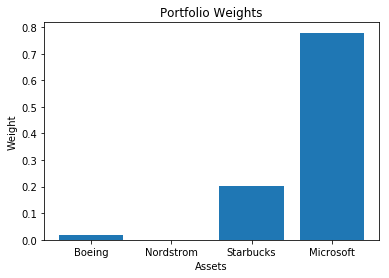

In [19]:
# risk free rate
t_bill_rate = 0.005

er = np.asarray([mu_hat_month]).T

# Tangency portfolio short sales allowed
tangency_portfolio_short = tangency_portfolio(er, cov_mat_month, riskFreeRate=t_bill_rate, short=True)

print(tangency_portfolio_short)
#plot
plt.figure();
plt.bar(range(n), tangency_portfolio_short['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# Tangency portfolio short sales not allowed
tangency_portfolio_no_short = tangency_portfolio(er, cov_mat_month, riskFreeRate=t_bill_rate, short=False)

print(tangency_portfolio_no_short)
#plot
#Plot the optimial weight
plt.figure();
plt.bar(range(n), tangency_portfolio_no_short['weight'])
plt.xticks(range(n), returns_df.columns)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()